In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import math
import json
import os
import wandb
from datasets import get_real_dataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

color_pallete = "colorblind"
cb = list(sns.color_palette(color_pallete))
color_pallete = "rocket"
rocket = list(sns.color_palette(color_pallete))

sns.set_palette([cb[4] ,cb[-2], cb[3], cb[0], cb[-4], rocket[0]])

In [13]:
dataset_names = ["Entacmaea","SGEMM","GB1_reduced","avGFP"]
plot_names = ["Entacmaea ($n=13$)","SGEMM ($n=40$)","GB1 ($n=80$)","avGFP ($n=236$)"]

## Size-R2 plot

In [11]:
# Load

training_methods = []
renames ={
        "normal": "standard",
        "hashing": "HashWH (Ours)",
}
dataset_best_results, dataset_runtimes = {}, {}

for dataset_name in dataset_names:
    file = f"files/{dataset_name}.json"
    with open(file) as f:
        dumped_data = json.load(f)
        best_results = dumped_data["best_results"]
        runtimes = dumped_data["runtimes"]
    
    train_sizes = list(best_results.keys())

    for train_size in train_sizes:
        best_results[int(train_size)] = best_results.pop(train_size)
        runtimes[int(train_size)] = runtimes.pop(train_size)
        training_methods = list(best_results[int(train_size)].keys())

    # Rename methods for plotting
    new_methods = {k:k for k in training_methods}
    for name, replacement in renames.items():
        for method in new_methods.keys():
            new_methods[method] = new_methods[method].replace(name, replacement)

    for train_size in best_results.keys():
        for method, new_name in new_methods.items():
            best_results[train_size][new_name] = best_results[train_size].pop(method)
            runtimes[train_size][new_name] = runtimes[train_size].pop(method)

    dataset_best_results[dataset_name] = best_results
    dataset_runtimes[dataset_name] = runtimes

/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8, 0.47058823529411764, 0.7372549019607844)) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.9254901960784314, 0.8823529411764706, 0.2)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.8352941176470589, 0.3686274509803922, 0.0)) for an unfilled marker

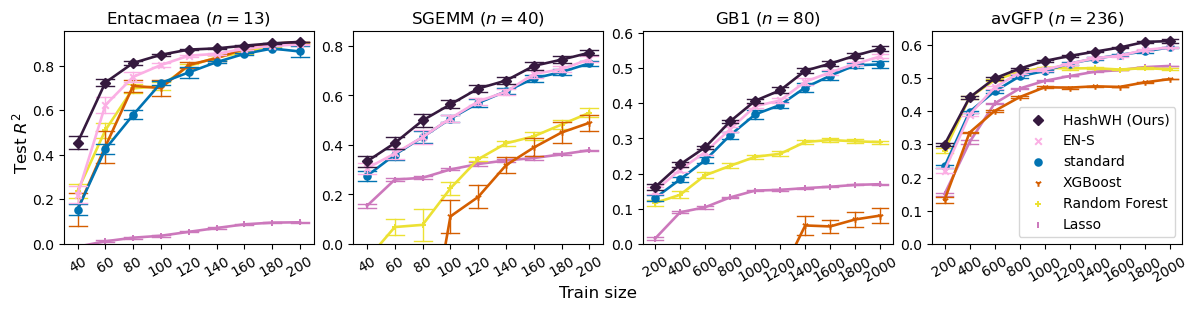

In [83]:
markers = ['|', '+', '1', 'o', 'x', 'D', 'p', '8', 's', 'p', 'D', 'V']

scale = 0.7
fig, axes = plt.subplots(1, len(dataset_names), figsize=(12, 3.1), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
for i, (dataset_name, plot_name) in enumerate(zip(dataset_names, plot_names)):
    results = {"Training method":[], "Train size": [], "Validation R2": [], "Runtime": []}
    best_results = dataset_best_results[dataset_name]
    runtimes = dataset_runtimes[dataset_name]
    for train_size in best_results.keys():
        for training_method in new_methods.values():
            results["Training method"].extend([training_method] * len(best_results[train_size][training_method]))
            results["Train size"].extend([train_size] * len(best_results[train_size][training_method]))
            results["Validation R2"].extend(best_results[train_size][training_method])
            results["Runtime"].extend(runtimes[train_size][training_method])
    g = sns.pointplot(x="Train size", y="Validation R2", hue="Training method",errorbar='se', scale=scale,
                capsize=.65, data=pd.DataFrame.from_dict(results), errwidth=1, ax=axes[i], markers=markers)
    # ax.set_ylabel("Test $R^2$")
    g.set(ylim=(0, None))
    axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)
    axes[i].set_title(plot_name)
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(30)

    if i != len(dataset_names) - 1:
    # if i != 0:
        axes[i].get_legend().remove()
    else:
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles[::-1], labels[::-1], loc='lower right').set_zorder(102)
fig.supylabel("Test $R^2$", y= 0.55, x=0.01)
fig.supxlabel("Train size", y=0.04)
fig.tight_layout(pad=0.5, w_pad=-0.1)

plt.savefig(f'files/merged_real_data_score.pdf')
